# Surface Mass Balance 

Import relevant Libaries 

In [1]:
%pip install pyarrow
%pip install plotly
%pip update pandas

You should consider upgrading via the '/Users/nilsfulde/opt/anaconda3/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.
You should consider upgrading via the '/Users/nilsfulde/opt/anaconda3/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.
ERROR: unknown command "update"
Note: you may need to restart the kernel to use updated packages.


In [5]:
# Base libraries
import pandas as pd
import numpy as np
import os
import math as math
import datetime
from scipy import stats

# Visualizations
import matplotlib.pyplot as plt

import plotly.express as px
import plotly.graph_objects as go

In [6]:
from scipy.interpolate import interp1d
from sklearn.linear_model import LinearRegression
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)

Set WD

In [1]:
import os

from pyrsistent import v
os.getcwd()
#os.chdir('/Users/asgerlyngeholst-hansen/Desktop/GEUS-Master-Thesis/')
#os.chdir('C:\\Users\\nifu18ab\\Desktop\\GEUS-Master-Thesis')
os.chdir('/Users/nilsfulde/Desktop/GEUS-Master-Thesis')
#os.chdir('/Users/nilsfulde/Desktop/Master_Thesis')


**Load New Promice Data**

In [7]:
#Function for loading data and converting to datetime 
def load_promice(path_to_file):
    '''
    Loading PROMICE data for a given path into a DataFrame.
    + adding time index
    
    INTPUTS:
        path_to_file: Path to the desired file containing PROMICE data [string]
    
    OUTPUTS:
        df: Dataframe containing PROMICE data for the desired settings [DataFrame]
    '''

    df = pd.read_parquet(path_to_file, engine='pyarrow')
    df['time'] = pd.to_datetime(df.time, utc=True)
    df = df.set_index('time')
    return df




In [8]:
x = load_promice('data/new_promice/all_promice_data_hourly.parquet.gzip')

In [9]:
x.stid.unique()

array(['CEN1', 'CEN2', 'CP1', 'DY2', 'EGP', 'HUM', 'JAR', 'JAR_O',
       'KAN_B', 'KAN_L', 'KAN_M', 'KAN_U', 'KPC_Lv3', 'KPC_L', 'KPC_Uv3',
       'KPC_U', 'LYN_L', 'LYN_T', 'MIT', 'NAE', 'NAU', 'NEM', 'NSE',
       'NUK_K', 'NUK_L', 'NUK_N', 'NUK_Uv3', 'NUK_U', 'QAS_A', 'QAS_Lv3',
       'QAS_L', 'QAS_M', 'QAS_Uv3', 'QAS_U', 'Roof_GEUS', 'Roof_PROMICE',
       'SCO_L', 'SCO_U', 'SDL', 'SDM', 'SWC', 'SWC_O', 'TAS_A', 'TAS_L',
       'TAS_U', 'THU_L2', 'THU_L', 'THU_U2', 'THU_U', 'TUN', 'UPE_L',
       'UPE_U', 'UWN', 'WEG_B', 'ZAK_L', 'ZAK_Uv3', 'ZAK_U'], dtype=object)

In [10]:
df = x[x["stid"] == "KAN_L"]

**Helper functions (Comment Nils: Not needed)**

In [ ]:
#Function for writing to Markdown Report
def Msg(txt):
    f = open("out/Report.md", "a")
    print(txt)
    f.write(txt + "\n")

In [91]:
#For outlier detecttion and filter 
def hampel(vals_orig, k=7*24, t0=3):
    '''
    vals: pandas series of values from which to remove outliers
    k: size of window (including the sample; 7 is equal to 3 on either side of value)
    '''
    #Make copy so original not edited
    vals=vals_orig.copy()    
    #Hampel Filter
    L= 1.4826
    rolling_median=vals.rolling(k).median()
    difference=np.abs(rolling_median-vals)
    median_abs_deviation=difference.rolling(k).median()
    threshold= t0 *L * median_abs_deviation
    outlier_idx=difference>threshold
    outlier_idx[0:round(k/2)]=False
    vals.loc[outlier_idx]=np.nan
    return(vals)

**Identifying ablation periods**

###### I think this is the one

In [11]:
# defining ice ablation period   
smoothed_PT =  df['z_pt_cor'].interpolate(limit=72).rolling('14D', min_periods=1).mean().shift(-7*14/2, freq='h')
smoothed_PT = smoothed_PT.rolling('14D', min_periods=1).mean().shift(-7*14/2, freq='h')

threshold_ablation = -0.0002 # Modify value if needed
ind_ablation = np.logical_and(smoothed_PT.diff().values < threshold_ablation, 
                              np.isin(smoothed_PT.diff().index.month, [6, 7, 8, 9]))

ind_ablation = np.concatenate((ind_ablation[4*24:], np.repeat(ind_ablation[-(4*24):-(4*24-1)], 4*24)))

df['Ablation'] = ind_ablation.tolist()


/var/folders/_r/2f7t_cz14232jqp3576_p04m0000gn/T/ipykernel_40107/2904398929.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Ablation'] = ind_ablation.tolist()


In [121]:
df.to_csv('KAN_L.csv', index=False)

-------------------------------------------------------------------------------------------------------------------

In [12]:
idx = np.argwhere(np.diff(np.r_[False,ind_ablation, False])).reshape(-1, 2)
idx[:, 1] -= 1

# here we fill small gaps in the ice ablation periods.
for i in range(len(idx)-1):
    ind = idx[i]
    ind_next = idx[i+1]
    if ind_next[0]-ind[1]<(24*15):
        ind_ablation[ind[1]:ind_next[0]]=True

#adjusting Snow and Surface heights to the PT-derived height
hs1=df["z_surf_1_adj"].interpolate(limit=24*2).copy()
hs2=df["z_surf_2_adj"].interpolate(limit=24*2).copy()
z=df["z_pt_cor_adj"].interpolate(limit=24*2).copy()

if any(~np.isnan(hs1.iloc[:24*7])):
    hs1 = hs1 - hs1.iloc[:24*7].mean()
if any(~np.isnan(z.iloc[:24*7])):
    hs2 = hs2 - hs2.iloc[:24*7].mean()
if any(~np.isnan(z.iloc[:24*7])):
    z = z - z.iloc[:24*7].mean()
elif np.any(~np.isnan(z)):
    # here we remove the intercept in the pressure transducer data. In many cases, the pressure transducer was installed few years after the installation of the main AWS. Removing the intercept means that we consider the ice surface height at 0 when the AWS is installed, and not when the pressure transducer is installed.
    Y = z.iloc[:].values.reshape(-1, 1)
    X = z.iloc[~np.isnan(Y)].index.astype(np.int64).values.reshape(-1, 1) 
    Y = Y[~np.isnan(Y)] 
    linear_regressor = LinearRegression()  
    linear_regressor.fit(X, Y)
    Y_pred = linear_regressor.predict(z.index.astype(np.int64).values.reshape(-1, 1) )
    z = z-Y_pred[0]

years = df.index.year.unique().values
ind_start = years.copy()
ind_end =  years.copy()



<Figure size 432x288 with 0 Axes>

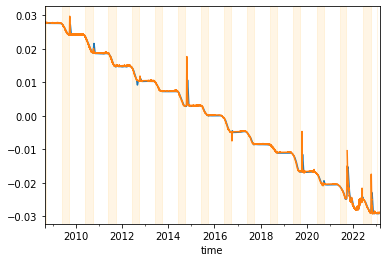

<Figure size 432x288 with 0 Axes>

In [16]:
for i, y in enumerate(years):
#for each year
    ind_yr = df.index.year.values == y
    ind_abl_yr = np.logical_and(ind_yr, ind_ablation)
    if np.any(ind_abl_yr):
        # if there are some ablation flagged for that year
        # then find begining and end
        ind_start[i] = np.argwhere(ind_abl_yr)[0][0]
        ind_end[i] = np.argwhere(ind_abl_yr)[-1][0]

    # elif np.any(np.isin(df.index[ind_yr].month.values, [6, 7, 8])):
    #     # if there is any data from june-august that year
    #     # then use first and last day of JJA as ablation season
    #     ind_abl_yr = np.logical_and(ind_yr, np.isin(df.index.month.values, [6, 7, 8]))
    #     ind_start[i] = np.argwhere(ind_abl_yr)[0][0]
    #     ind_end[i] = np.argwhere(ind_abl_yr)[-1]
    #     ind_ablation[ind_start[i]:ind_end[i]] = True
    #     ind_accumulation[ind_start[i]:ind_end[i]] = False
    else:
        # otherwise left as nan
        ind_start[i] = -999
        ind_end[i] = -999

plt.figure()
((smoothed_PT-smoothed_PT.mean())/1000).plot()
((z-z.mean())/1000).plot()

#smoothed_PT.diff().plot()
#plt.axhline(threshold_ablation)

for i, y in enumerate(years):
    plt.axvspan(df.index[ind_start[i]],df.index[ind_end[i]], color='orange', alpha=0.1)

plt.figure()

2008
adjusting hs2 to z
using end of melt season
2009
adjusting hs2 to z
using end of melt season
adjusting hs1
to hs2
2010
adjusting hs2 to z
using end of melt season
adjusting hs1
to hs2
2011
adjusting hs2 to z
using end of melt season
adjusting hs1
to hs2
2012
adjusting hs2 to z
using end of melt season
2013
adjusting hs2 to z
using end of melt season
2014
adjusting hs2 to z
using end of melt season
2015
adjusting hs2 to z
using end of melt season
2016
adjusting hs2 to z
using end of melt season
adjusting hs1
to hs2
2017
adjusting hs2 to z
using end of melt season
2018
adjusting hs2 to z
using end of melt season
2019
adjusting hs2 to z
using end of melt season
2020
adjusting hs2 to z
using end of melt season
adjusting hs1
to hs2
2021
adjusting hs2 to z
using end of melt season
adjusting hs1
to hs2
2022
adjusting hs2 to z
using end of melt season
adjusting hs1
to hs2
2023
no ablation
no hs2


/var/folders/_r/2f7t_cz14232jqp3576_p04m0000gn/T/ipykernel_40107/1404800862.py:137: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["z_surf_1_adj"] = hs1.interpolate(limit=2*24).values
/var/folders/_r/2f7t_cz14232jqp3576_p04m0000gn/T/ipykernel_40107/1404800862.py:138: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["z_surf_2_adj"] = hs2.interpolate(limit=2*24).values
/var/folders/_r/2f7t_cz14232jqp3576_p04m0000gn/T/ipykernel_40107/1404800862.py:139: SettingWithCopyWarning: 
A value is trying to be set on 

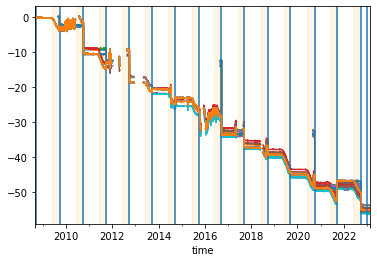

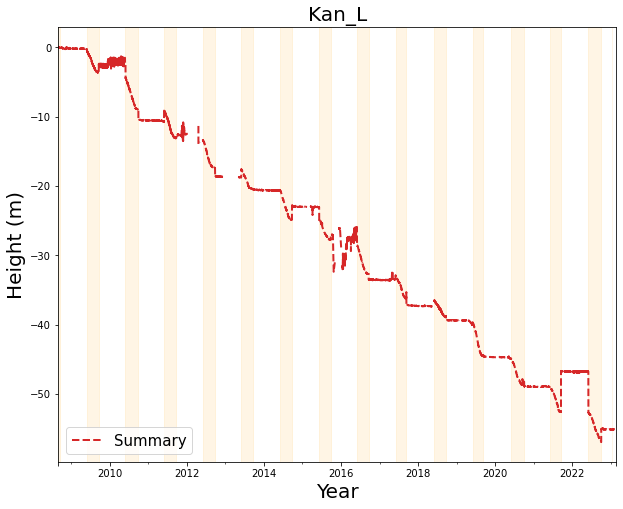

In [17]:
# adjustement loop
hs2_ref = 0 # by default, the PT is the reference: hs1 and 2 will be adjusted to PT
missing_hs2 = 0 # if hs2 is missing then when it comes back it is adjusted to hs1

for i, y in enumerate(years):
    print(y)
    if all(np.isnan(z[str(y)+'-06-01':str(y)+'-09-01'])) and any(~np.isnan(hs2[str(y)+'-06-01':str(y)+'-09-01'])):
        # if there is no PT for a given year, but there is some hs2
        # then hs2 is the reference
        hs2_ref = 1

    if hs2_ref == 1:
        if ind_start[i] != -999:
            # the first year there is both ablation and PT data available
            # then PT is adjusted to hs2
            if any(~np.isnan(z.iloc[ind_start[i]:ind_end[i]])) and any(~np.isnan(hs2.iloc[ind_start[i]:ind_end[i]])):

                    tmp1 = z.iloc[ind_start[i]:ind_end[i]].copy()
                    tmp2 = hs2.iloc[ind_start[i]:ind_end[i]].copy()
                    tmp1[np.isnan(tmp2)] = np.nan
                    tmp2[np.isnan(tmp1)] = np.nan

                    # in some instances, the PT data is available but not ablation
                    # is recorded, then hs2 remains the reference during that time.
                    # When eventually there is ablation, then we need to find the 
                    # first valid index in these preceding ablation-free years
                    # the shit will be applied back from this point
                    first_index = z[:z[str(y)+'-01-01':str(y)+'-12-31'].first_valid_index()].isnull().iloc[::-1].idxmax()
                    z[first_index:] = z[first_index:] -  np.nanmean(tmp1)  +  np.nanmean(tmp2)
                    z.plot()
                    hs2_ref = 0 # from now on PT is the reference


    # adapting hs2
    # if there is some ablation
    if (ind_end[i] != -999): 
        # and if there are PT data available at the end of the melt season
        if np.any(~np.isnan(z.iloc[(ind_end[i]-24*7):(ind_end[i]+24*7)])):
            print('adjusting hs2 to z')
            # then we adjust hs2 to the end-of-ablation z    
            # first trying at the end of melt season
            if ~np.isnan(np.nanmean(hs2.iloc[(ind_end[i]-24*7):(ind_end[i]+24*30)])): 
                print('using end of melt season')
                hs2.iloc[ind_end[i]:] = hs2.iloc[ind_end[i]:] - \
                    np.nanmean(hs2.iloc[(ind_end[i]-24*7):(ind_end[i]+24*30)])  + \
                        np.nanmean(z.iloc[(ind_end[i]-24*7):(ind_end[i]+24*30)])
            # if not possible, then trying the end of the following accumulation season
            elif (i+1 < len(ind_start)):
                if ind_start[i+1]!=-999 and any(~np.isnan(hs2.iloc[(ind_start[i+1]-24*7):(ind_start[i+1]+24*7)]+ z.iloc[(ind_start[i+1]-24*7):(ind_start[i+1]+24*7)])): 
                    print('using end of accumulation season')
                    hs2.iloc[ind_end[i]:] = hs2.iloc[ind_end[i]:] - \
                        np.nanmean(hs2.iloc[(ind_start[i+1]-24*7):(ind_start[i+1]+24*7)])  + \
                            np.nanmean(z.iloc[(ind_start[i+1]-24*7):(ind_start[i+1]+24*7)])
    else:
        print('no ablation')
        if all(np.isnan(hs2[str(y)+'-09-01':str(y+1)+'-03-01'])):
            print('no hs2')
            missing_hs2 = 1
        elif missing_hs2 == 1:
            print('adjusting hs2')
            # and if there are some hs2 during the accumulation period
            if any(~np.isnan(hs1[str(y)+'-09-01':str(y+1)+'-03-01'])):
                print('to hs1')
                # then we adjust hs1 to hs2 during the accumulation area
                # adjustment is done so that the mean hs1 and mean hs2 match 
                # for the period when both are available
                tmp1 = hs2[str(y)+'-09-01':str(y+1)+'-03-01'].copy()
                tmp2 = hs1[str(y)+'-09-01':str(y+1)+'-03-01'].copy()

                tmp1[np.isnan(tmp2)] = np.nan
                tmp2[np.isnan(tmp1)] = np.nan

                hs2[str(y)+'-01-01':] = hs2[str(y)+'-01-01':] -  np.nanmean(tmp1)  +  np.nanmean(tmp2)
                missing_hs2 = 0

        # adjusting hs1 to hs2 (no ablation case)
        if any(~np.isnan(hs1[str(y)+'-09-01':str(y+1)+'-03-01'])):
            print('adjusting hs1')
            # and if there are some hs2 during the accumulation period
            if any(~np.isnan(hs2[str(y)+'-09-01':str(y+1)+'-03-01'])):
                print('to hs2')
                # then we adjust hs1 to hs2 during the accumulation area
                # adjustment is done so that the mean hs1 and mean hs2 match 
                # for the period when both are available
                tmp1 = hs1[str(y)+'-09-01':str(y+1)+'-03-01'].copy()
                tmp2 = hs2[str(y)+'-09-01':str(y+1)+'-03-01'].copy()

                tmp1[np.isnan(tmp2)] = np.nan
                tmp2[np.isnan(tmp1)] = np.nan

                hs1[str(y)+'-09-01':] = hs1[str(y)+'-09-01':] -  np.nanmean(tmp1)  +  np.nanmean(tmp2)


    if ind_end[i] != -999:
    # if there is some hs1
        if any(~np.isnan(hs1.iloc[ind_end[i]:min(len(hs1),ind_end[i]+24*30*9)])):
            print('adjusting hs1')
            # and if there are some hs2 during the accumulation period
            if any(~np.isnan(hs2.iloc[ind_end[i]:min(len(hs2),ind_end[i]+24*30*9)])):
                print('to hs2')
                # then we adjust hs1 to hs2 during the accumulation area
                # adjustment is done so that the mean hs1 and mean hs2 match 
                # for the period when both are available
                tmp1 = hs1.iloc[ind_end[i]:min(len(hs1),ind_end[i]+24*30*9)].copy()
                tmp2 = hs2.iloc[ind_end[i]:min(len(hs2),ind_end[i]+24*30*9)].copy()

                tmp1[np.isnan(tmp2)] = np.nan
                tmp2[np.isnan(tmp1)] = np.nan

                hs1.iloc[ind_end[i]:] = hs1.iloc[ind_end[i]:] -  np.nanmean(tmp1)  +  np.nanmean(tmp2)

            # if no hs2, then use PT data available at the end of the melt season
            elif np.any(~np.isnan(z.iloc[(ind_end[i]-24*7):(ind_end[i]+24*7)])):
                print('to z')
                # then we adjust hs2 to the end-of-ablation z    
                # first trying at the end of melt season
                if ~np.isnan(np.nanmean(hs1.iloc[(ind_end[i]-24*7):(ind_end[i]+24*30)])): 
                    print('using end of melt season')
                    hs1.iloc[ind_end[i]:] = hs1.iloc[ind_end[i]:] - \
                        np.nanmean(hs1.iloc[(ind_end[i]-24*7):(ind_end[i]+24*30)])  + \
                            np.nanmean(z.iloc[(ind_end[i]-24*7):(ind_end[i]+24*30)])
                # if not possible, then trying the end of the following accumulation season
                elif ind_start[i+1]!=-999 and any(~np.isnan(hs1.iloc[(ind_start[i+1]-24*7):(ind_start[i+1]+24*7)]+ z.iloc[(ind_start[i+1]-24*7):(ind_start[i+1]+24*7)])): 
                    print('using end of accumulation season')
                    hs1.iloc[ind_end[i]:] = hs1.iloc[ind_end[i]:] - \
                        np.nanmean(hs1.iloc[(ind_start[i+1]-24*7):(ind_start[i+1]+24*7)])  + \
                            np.nanmean(z.iloc[(ind_start[i+1]-24*7):(ind_start[i+1]+24*7)])


    hs1.plot()
    hs2.plot()
    plt.axvline(hs1.index[ind_end[i]])

    plt.axvspan(df.index[ind_start[i]],df.index[ind_end[i]], color='orange', alpha=0.1)


df["z_surf_1_adj"] = hs1.interpolate(limit=2*24).values
df["z_surf_2_adj"] = hs2.interpolate(limit=2*24).values
df["z_pt_cor_adj"] = z.interpolate(limit=2*24).values

# making a summary of the surface height
df["z_surf_combined"] = np.nan

# in winter, both SR1 and SR2 are used
df["z_surf_combined"] = np.nanmean( df[["z_surf_1_adj",
                                                 "z_surf_2_adj"]].values, 
                                            axis = 1)

# in ablation season we use SR2 instead of the SR1&2 average
# here two options:
# 1) we ignore the SR1 and only use SR2
# 2) we use SR1 when SR2 is not available (commented) 
# the later one can cause jumps when SR2 starts to be available few days after SR1
data_update = df["z_surf_2_adj"].interpolate(limit=72).values 
ind_update = ind_ablation 
#ind_update = np.logical_and(ind_ablation,  ~np.isnan(data_update))
df.loc[ind_update,"z_surf_combined"] = data_update[ind_update]  

# in ablation season we use pressure transducer over all other options
data_update = df[ "z_pt_cor_adj"].interpolate(limit=72).values 
ind_update = np.logical_and(ind_ablation, ~np.isnan(data_update))
df.loc[ind_update,"z_surf_combined"] = data_update[ind_update] 

# plotting result
f1 = plt.figure(figsize=(10, 8))    
#df["z_pt_cor_adj"].plot(label = 'Pressure transducer')
#df["z_surf_1_adj"].plot(label = 'SonicRanger1')
#df["z_surf_2_adj"].plot(label = 'SonicRanger2')
df["z_surf_combined"].plot(label = 'Summary',
         linestyle='--', linewidth=2, color = 'tab:red')

plt.legend(prop={'size': 15})
plt.xlabel('Year',size=20)
plt.ylabel('Height (m)',size=20)
plt.title("Kan_L",size=20)
#plt.grid()
for i, y in enumerate(years):
    plt.axvspan(df.index[ind_start[i]],df.index[ind_end[i]], color='orange', alpha=0.1)
#f1.savefig('figures/surface_height/'+"Kan_L"+'_surface_height.png',dpi=90, bbox_inches='tight')
#Msg('[![Surface height adjustement at '+ site+']'+\
#    '(../figures/surface_height/'+site+'_surface_height.png)]'+\
#        '(../figures/surface_height/'+site+'_surface_height.png)')

-------------------------- From previos script (Nils: can be deleted??) ----------------------------------------------

In [83]:
#Calling hampel function
df["z_pt_cor_adj"] = hampel(df["z_pt_cor"].interpolate(limit=72)).values
df["z_surf_1_adj"] = hampel(df["z_surf_1"].interpolate(limit=72)).values
df["z_surf_2_adj"] = hampel(df["z_surf_2"].interpolate(limit=72)).values

In [86]:
df.index.is_monotonic
df.sort_index(inplace=True)
df.index.is_monotonic

True

In [87]:
#Setting ablation thresholds and defining period --> Doesn't work 
#df = df.sort_index() # Added as the series was not monotonic for some reason
#df = df.reindex(sorted(df.index))
smoothed_PT =  df['z_pt_cor'].interpolate(limit=72).rolling('14D', min_periods=1).mean().shift(-7*14/2, freq='h')
smoothed_PT = smoothed_PT.rolling('14D', min_periods=1).mean().shift(-7*14/2, freq='h')
threshold_ablation = -0.0002 # Modify value if needed
ind_ablation = np.logical_and(smoothed_PT.diff().values < threshold_ablation, 
                                  np.isin(smoothed_PT.diff().index.month, [6, 7, 8, 9]))
ind_ablation = np.concatenate((ind_ablation[4*24:], np.repeat(ind_ablation[-(4*24):-(4*24-1)], 4*24)))

In [88]:
#Finding ablation periods in years
for i, y in enumerate(years):
    #for each year
        ind_yr = df.index.year.values==y
        ind_abl_yr = np.logical_and(ind_yr, ind_ablation)
        if np.any(ind_abl_yr):
            # if there are some ablation flagged for that year
            # then find begining and end
            ind_start[i] = np.argwhere(ind_abl_yr)[0][0]
            ind_end[i] = np.argwhere(ind_abl_yr)[-1][0]
            
        else:
            # otherwise left as nan
            ind_start[i] = -999
            ind_end[i] = -999


In [102]:
#Printing one site 'KAN_L' to indentify ablation periods
def plotsite(df,site):
        df = df[df["stid"] ==  site]
        f1 = plt.figure(figsize=(10, 8))    
        df["z_pt_cor_adj"].plot(label = 'Pressure transducer')
        df["z_surf_1_adj"].plot(label = 'SonicRanger1')
        df["z_surf_2_adj"].plot(label = 'SonicRanger2')
        df["z_surf_combined"].plot(label = 'Summary',
                linestyle='--', linewidth=2, color = 'tab:red')

        plt.legend(prop={'size': 15})
        plt.xlabel('Year',size=20)
        plt.ylabel('Height (m)',size=20)
        plt.title(site,size=20)
        plt.grid()

        plt.legend(prop={'size': 15})
        plt.xlabel('Year',size=20)
        plt.ylabel('Height (m)',size=20)
        plt.title(site,size=20)
        plt.grid()

        #For orange coloring of ablation periods
        for i, y in enumerate(years):
                plt.axvspan(df.index[ind_start[i]],df.index[ind_end[i]], color='orange', alpha=0.1)
        
        # Add figure to /figures
        f1.savefig('figures/'+site+'_surface_height.png',dpi=90, bbox_inches='tight')
        Msg('[![Surface height adjustement at '+ site+']'+\
                '(../figures/'+site+'_surface_height.png)]'+\
                '(../figures/'+site+'_surface_height.png)')


IndexError: index 3967222 is out of bounds for axis 0 with size 126821

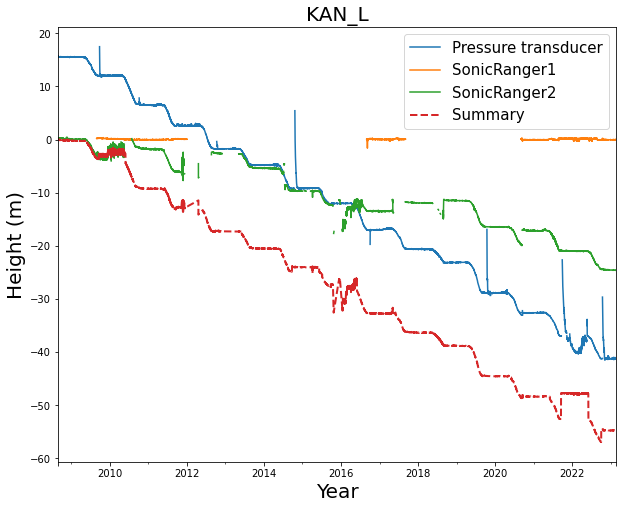

In [103]:
#Testing for KAN_L in specific period
df_abl = df['2017-01-05':'2017-08-30']

plotsite(df, 'KAN_L')

In [ ]:
# Takes some time - For all sites
for site in df.stid.unique().tolist():
    df = df[df["stid"] == site]
    f1 = plt.figure(figsize=(10, 8))    
    df["z_pt_cor_adj"].plot(label = 'Pressure transducer')
    df["z_surf_1_adj"].plot(label = 'SonicRanger1')
    df["z_surf_2_adj"].plot(label = 'SonicRanger2')
    df["z_surf_combined"].plot(label = 'Summary',
             linestyle='--', linewidth=2, color = 'tab:red')

    plt.legend(prop={'size': 15})
    plt.xlabel('Year',size=20)
    plt.ylabel('Height (m)',size=20)
    plt.title(site,size=20)
    plt.grid()
   # for i, y in enumerate(years):
   #     plt.axvspan(df.index[ind_start[i]],df.index[ind_end[i]], color='orange', alpha=0.1)